#Download Dataset and Setup Directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset comprises two main folders:

cat folder: Contains a series of RGB images depicting cats.

loaf folder: Contains a series of RGB images depicting cat loaves.

All images are in RGB format and have been standardized to a resolution of 100x100 pixels.The dataset consists of a total of 323 cat images and 323 cat loaves images, resulting in a combined total of 646 images.

In [ ]:
import os

# Path to the dataset directory
dataset_path = '/root/.cache/kagglehub/datasets/erogluegemen/cat-catloaf-classification/versions/1'

# List the files and subdirectories in the dataset folder
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    for file in files:
        print(f" - {file}")


#Preprocessing Images

This code preprocesses and prepares a dataset for a binary image classification task by organizing images into training and validation sets. It creates a structured directory for two categories, "cats" and "loafs," shuffles and splits the dataset based on a configurable ratio (default 80% training, 20% validation), resizes images to a uniform size of 100x100 pixels, and saves them in the respective directories. This ensures a standardized and organized dataset ready for training machine learning models.

In [ ]:
import os
import shutil
import random
from pathlib import Path
from PIL import Image

# Define dataset path based on your directory structure
dataset_path = '/root/.cache/kagglehub/datasets/erogluegemen/cat-catloaf-classification/versions/1/images'

# Define the root directory for training and validation splits in Google Drive
root_dir = '/content/drive/MyDrive/cats-v-loafs'

# Function to create training and validation directories
def create_train_val_dirs(root_path):
    training = os.path.join(root_path, 'training')
    validation = os.path.join(root_path, 'validation')

    # Create directories for categories
    os.makedirs(os.path.join(training, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(training, 'loafs'), exist_ok=True)
    os.makedirs(os.path.join(validation, 'cats'), exist_ok=True)
    os.makedirs(os.path.join(validation, 'loafs'), exist_ok=True)

# Create the directory structure
create_train_val_dirs(root_dir)

# Function to preprocess and split data
def preprocess_and_split_data(dataset_path, root_dir, split_ratio=0.8):
    # Define source paths for original images
    cat_images = list(Path(dataset_path, 'cat').glob('*.*'))  # Match all image extensions
    loaf_images = list(Path(dataset_path, 'loaf').glob('*.*'))  # Match all image extensions

    # Shuffle and split images into training and validation
    random.shuffle(cat_images)
    random.shuffle(loaf_images)

    cat_train = cat_images[:int(len(cat_images) * split_ratio)]
    cat_valid = cat_images[int(len(cat_images) * split_ratio):]
    loaf_train = loaf_images[:int(len(loaf_images) * split_ratio)]
    loaf_valid = loaf_images[int(len(loaf_images) * split_ratio):]

    # Save images in their respective directories
    def save_images(image_list, target_dir):
        for img_path in image_list:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((100, 100))
            img.save(os.path.join(target_dir, img_path.name))

    # Save processed images to training and validation directories
    save_images(cat_train, os.path.join(root_dir, 'training', 'cats'))
    save_images(cat_valid, os.path.join(root_dir, 'validation', 'cats'))
    save_images(loaf_train, os.path.join(root_dir, 'training', 'loafs'))
    save_images(loaf_valid, os.path.join(root_dir, 'validation', 'loafs'))

# Run preprocessing and split data
preprocess_and_split_data(dataset_path, root_dir)

#Dataset inspection

#Set up data generator

This code sets up data generators for training and validation using TensorFlow's ImageDataGenerator. It applies data augmentation to the training data (rescaling pixel values to [0, 1], rotating images, shifting width and height, and flipping horizontally) to enhance model generalization. For validation data, only rescaling is applied. The flow_from_directory method loads images from the organized directories (training and validation) and generates batches of resized images (100x100 pixels) with binary labels for the classification task. These generators provide a streamlined pipeline for feeding augmented and standardized data into a deep learning model.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators with augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(root_dir, 'training'),
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    directory=os.path.join(root_dir, 'validation'),
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary'
)

Found 516 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


#Set Up the Model Architecture
We have used a Convolutional Neural Network (CNN) since CNNs are well-suited for image classification tasks. This code classifies images from the dataset into two categories: "cat" and "loaf." The model processes the dataset's 100x100 pixel images by applying three convolutional layers with ReLU activation for feature extraction, followed by max-pooling layers to reduce the spatial dimensions and focus on the most significant features. The flattened output is passed through a dense layer with 128 units, a dropout layer to reduce overfitting, and a final dense layer with a sigmoid activation for binary classification.

The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric. This architecture prepares the model to effectively learn patterns and features from the preprocessed and augmented dataset, ensuring it can generalize well to unseen images. Here’s an outline of the model setup in TensorFlow/Keras:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (cat vs loaf)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

#Training the model

This section of the code involves key steps for training, evaluating, visualizing, and saving a Convolutional Neural Network (CNN) designed to classify "cat" and "cat loaf" images. Each part plays an essential role in the machine learning workflow, ensuring the model is trained effectively and can be reused for future predictions or fine-tuning.

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 774ms/step - accuracy: 0.4783 - loss: 0.7004 - val_accuracy: 0.5385 - val_loss: 0.6832
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 673ms/step - accuracy: 0.5804 - loss: 0.6782 - val_accuracy: 0.5692 - val_loss: 0.7060
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 732ms/step - accuracy: 0.5754 - loss: 0.6588 - val_accuracy: 0.6000 - val_loss: 0.6697
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 674ms/step - accuracy: 0.5786 - loss: 0.6677 - val_accuracy: 0.6154 - val_loss: 0.6557
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.6315 - loss: 0.6450 - val_accuracy: 0.6231 - val_loss: 0.6508
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 755ms/step - accuracy: 0.6475 - loss: 0.6339 - val_accuracy: 0.6615 - val_loss: 0.6498
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 617ms/step - accuracy: 0.6481 - loss: 0.6292 - val_accuracy: 0.6231 - val_loss: 0.6398
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 672ms/step - accuracy: 0.6959 - loss: 0.6027 - val_accuracy: 0.669

#Evaluate the model

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.6567 - loss: 0.6212
Validation Loss: 0.6186696887016296
Validation Accuracy: 0.6615384817123413


#Visualize the training results

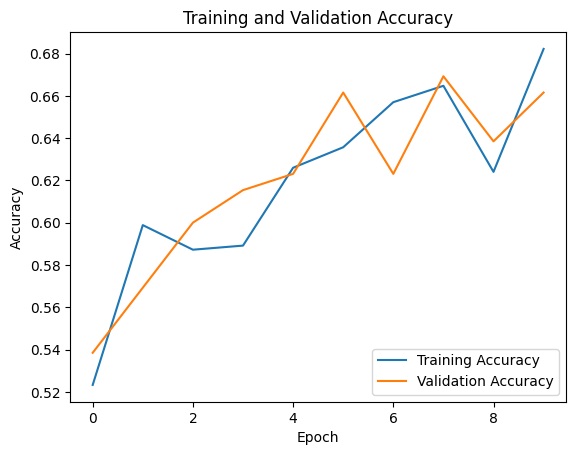

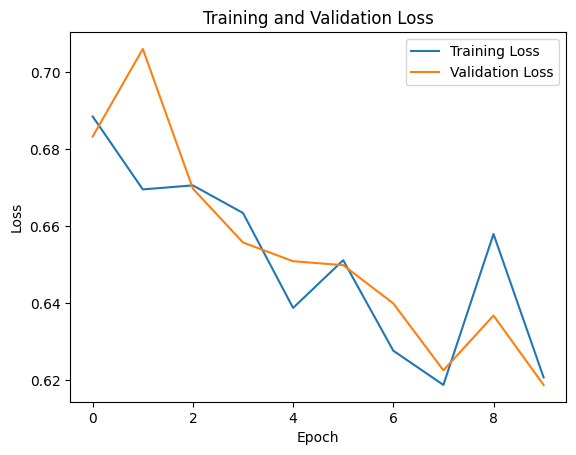

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#Save the model

The Convolutional Neural Network (CNN) successfully learns to classify "cat" and "cat loaf" images, achieving a validation accuracy of approximately 66% and a validation loss of ~0.62. These results indicate that the model has captured meaningful patterns and features from the dataset, enabling it to generalize reasonably well to unseen data.

The steady improvement in training accuracy and the close alignment of training and validation loss suggest that the model is not overfitting significantly. However, the performance indicates room for improvement, such as:

* Enhancing the dataset with more examples or better augmentation techniques.

* Experimenting with more complex architectures or hyperparameter tuning.


In [ ]:
model.save('/content/drive/MyDrive/cat_vs_loaf_classifier.h5')